# ROB 498: Robot Learning for Planning and Control
# Assignment 4: Learning Dynamics with Gaussian Processes

## Colab Setup

In [ ]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a ROB498 folder and put all the files under HW3 folder, then 'ROB498/HW4'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ROB498/HW4'

### Setup Code 

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [1]:
import os
import sys

GOOGLE_DRIVE_PATH = './'

files = os.listdir(GOOGLE_DRIVE_PATH)
expected_files = ['ROB498_hw4.ipynb', 
                  'gpytorch_intro.py', 
                  'learning_uncertain_dynamics.py', 
                  'mppi.py', 
                  'utils.py', 
                  'visualizers.py', 
                  'panda_pushing_env.py',
                  'q1_train_data.npz',
                  'pushing_training_data.npy', 
                  'pushing_validation_data.npy', 
                  'visualization_data.npz', 
                 ]

sys.path.append(GOOGLE_DRIVE_PATH)

# Verify that there are all the expected files in the directory
all_found = True
for expected_file in expected_files:
  if expected_file not in files:
    print(f'Required file {expected_file} not found!')
    all_found = False
if all_found:
  print('All required files are found :)')

All required files are found :)


In [ ]:
# Install missing required packages 
# Unfortunately Colab does not have pybullet package by default, so we will have to install it every time that the notebook kernel is restarted.
# Install pybullet -- For simulation purposes
!pip install pybullet
# Install numpngw -- For visualization purposes
!pip install numpngw
# Install GPyTorch
!pip install 

In [3]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numpngw import write_apng
from IPython.display import Image
from tqdm.notebook import tqdm
import gpytorch

## Assignment Introduction

Due 4/2 at 11:59pm

**Rules**:

1. All homework must be done individually, but you are encouraged to post questions on Piazza

2. No late homework will be accepted (unless you use your late-day tokens)

3. Submit your code on [autograder.io](http://autograder.io/)

4. Remember that copying-and-pasting code from other sources is not allowed

5. The use of additional package imports beyound the packages we provide is not allowed. The autograder will not grade your code if you use additional packages.

**Instructions**
- Each problem will give you a file with some template code, and you need to fill in the
rest.
- We use the autograder, so if you’re ever wondering “will I get full points for
this?” just upload your code in the autograder to check. There is no limit to how
many times you can upload to autograder.
- The autograder may test your problem with multiple different inputs to make sure it is correct.
- The autograder will only show you if you got it right/wrong, so if you don’t get full points, try to test with some other inputs.

# 1. Introduction to GPyTorch (20 points)

In this section you will use GPyTorch to fit a Gaussian Process (GP) to the following 1D function


$$ y = \sin (\pi x) + 1.73 x $$

Where the data is corrupted by noise. We will explore how different choices of kernels affect the resulting GP fit. 



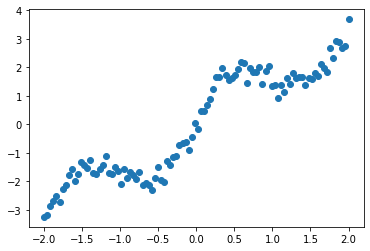

In [4]:
from gpytorch_intro import *

# First load the training data
train_data = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'q1_train_data.npz' ), allow_pickle=True)

train_x = torch.from_numpy(train_data['x'])
train_y = torch.from_numpy(train_data['y'])

test_x = torch.linspace(-3, 3, 100) 

plt.scatter(train_x, train_y)
plt.show()


## 1.1 Training a GP with an RBF kernel (10 points)

One of the most common kernels used in GP regression is the scaled Radial Basis Function (RBF) kernel, which is shown in the lecture slides. 
$$ k(x, x') = \sigma ^2 e^{-\frac{1}{2l^2} (x-x')^T(x-x')}$$
The GPytorch RBF kernel is
$$ k(x, x') = e^{-\frac{1}{2l^2} (x-x')^T(x-x')}$$
To incorporate $\sigma^2$ you must compose the RBF kernel with a Scale Kernel. These kernels are `gpytorch.kernels.RBFKernel` and `gpytorch.kernels.ScaleKernel` respectively. 

### 1.1 a) Creating a GP with an RBF kernel (5 points)

- Complete the function `RBF_GP.__init__` by defining `self.mean_module` and `self.covar_module`
- You should use a zero-mean function
- You should use the RBF kernel with the Scale Kernel

In [5]:
# Define the RBF GP with a Gaussian likelihood
rbf_likelihood = gpytorch.likelihoods.GaussianLikelihood()
rbf_model = RBF_GP(train_x, train_y, rbf_likelihood)


print('Kernel function is correctly defined: ')

print(
    isinstance(rbf_model.covar_module, gpytorch.kernels.ScaleKernel) and 
    isinstance(rbf_model.covar_module.base_kernel, gpytorch.kernels.RBFKernel)
)

print('')
print('Mean function is correctly defined: ')
print(isinstance(rbf_model.mean_module, gpytorch.means.ZeroMean))


Kernel function is correctly defined: 
True

Mean function is correctly defined: 
True


### 1.1 b) Optimizing GP hyperparameters (5 points)

When we initialize a GP with GPytorch it will initialize with some set of hyperparameters for the Kernel and the likelihood. Let's see what happens when we use the initial hyperparameters

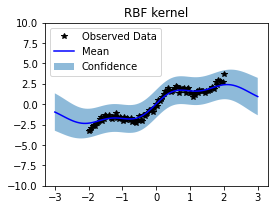

In [6]:
# Define the RBF kernel GP model
rbf_likelihood = gpytorch.likelihoods.GaussianLikelihood()
rbf_model = RBF_GP(train_x, train_y, rbf_likelihood)

# Plot the resulting fit GP
plot_gp_predictions(rbf_model, rbf_likelihood, train_x, train_y, test_x, title='RBF kernel')

This fit is OK, but it is treating a lot of the variation in the data as noise. We can improve the fit by optimizing the GP hyperparameters. 

- Complete the function `train_gp_hyperparams` in `gpytorch_intro.py`
- Your function should use Adam to optimize the GP hyperparameters
- You can use the code from the lecture as a guide

You should see a much tighter fit to the data, with large increases in uncertainty where we do not have data. 

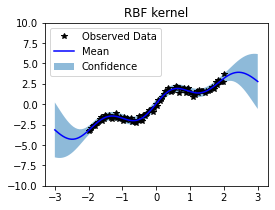

In [7]:
# Define the RBF kernel GP model
rbf_likelihood = gpytorch.likelihoods.GaussianLikelihood()
rbf_model = RBF_GP(train_x, train_y, rbf_likelihood)

# Optimize the hyperparameters
train_gp_hyperparams(rbf_model, rbf_likelihood, train_x, train_y, lr=0.1)

# Plot the resulting fit GP
plot_gp_predictions(rbf_model, rbf_likelihood, train_x, train_y, test_x, title='RBF kernel')

### 1.2 Using a polynomial Kernel (5 points)

Now let's try the Polynomial kernel. This is a kernel of the form

$$k(x, x') = (x^Tx' + c)^d$$

Where $d$ is the degree, and $c$ is a kernel hyperparameter.  

We would use this kernel if we suspected a polynomial of degree $d$ could fit our data well. 

You should do the following
- Complete the function `PolynomialGP.__init__`
- You should use a zero-mean function
- You should use a Polynomial Kernel
- You should compose your polynomial kernel with a scale kernel as you did in the previous question with the RBF kernel



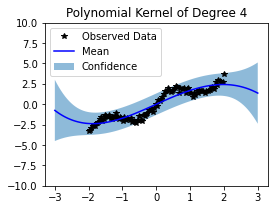

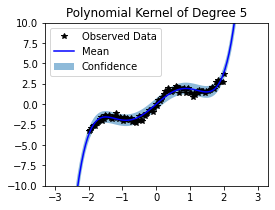

In [8]:
# Let's look and how these kernels perform for two different degrees

for degree in [4, 5]:
    # Now let's try a Polynomial Kernel
    polynomial_likelihood = gpytorch.likelihoods.GaussianLikelihood()
    polynomial_model = PolynomialGP(train_x, train_y, polynomial_likelihood, degree=degree)

    # train it
    train_gp_hyperparams(polynomial_model, polynomial_likelihood, train_x, train_y, lr=0.1)

    # Plot
    plot_gp_predictions(polynomial_model, polynomial_likelihood, train_x, train_y, test_x, title=f'Polynomial Kernel of Degree {degree}')



From above we can see that a polynomial of degree 4 seems to underfit the data, while a polynomial of degree 5 seeems to overfit the data. For a polynomial of degree 5, the uncertainty seems to actually decrease away from the data!

While GPs are generally robust to overfitting, we can see that an improper choice of kernel can lead to both poor overfitting and underfitting. 

## 1.3 Linear Kernel + Cosine Kernel

We can compose kernels by addition. Thus 
$$k(x, x') = k_1(x, x') + k_2(x, x')$$ 

is a valid kernel which we can use in our GP, provided $k_1$ and $k_2$ are kernels.

We will use the following two kernels:
1. The Linear Kernel $k(x, x') = x^T x' + c$
2. The Cosine Kernel $k(x, x') = \cos \left( \pi \frac{||x - x'||_2}{p} \right) $

$c$ and $p$ are both kernel hyperparameters. Using a linear kernel is a good choice if you suspect that a linear function will fit the data well, and a cosine kernel is a good choice for periodic data. 

You can compose kernels additively in GPytorch using the `+` operator on two kernel instances.

You should do the following
- Complete `LinearCosineGP.__init__` 
- You should use a zero-mean function
- You should additively compose a Linear Kernel and a Cosine Kernel, and compose this combined kernel with the Scale kernel as you have done in the previous questions. The combined kernel should be $\sigma^2(k_{Linear}(x, x') + k_{Cosine}(x, x'))$

In [ ]:
# Now let's try a Linear + Cosine Kernel
lincos_likelihood = gpytorch.likelihoods.GaussianLikelihood()
lincos_model = LinearCosineGP(train_x, train_y, lincos_likelihood)

# train it
train_gp_hyperparams(lincos_model, lincos_likelihood, train_x, train_y, lr=0.1)

# Plot
plot_gp_predictions(lincos_model, lincos_likelihood, train_x, train_y, test_x, title='Linear + Cosine kernel')



Using the Linear + Cosine Kernel produces a good fit to the data, and a reasonable extrapolation. In fact, in this instance the GP captures the underlying function meaning this extrapolation is very accurate. 

However, note that our original function is an additive composition of a linear term and a periodic term, thus the linear cosine kernel can perform very well. Choosing a very specific kernel is only possible when we have a lot of prior knowledge about the underlying function. 

The RBF kernel is often a good choice when we have less prior knowledge, as it can fit the data well while giving high uncertainty in low-data regions of the input space. 

# 2. Learning Planar Pushing Dynamics with Uncertainty

For this question you will learn a model which will be used with MPPI so that a robot can push an object to a goal. Unlike in homework 3, however, you will be using learning methods which incorporate model uncertainty. You will also train a model on a much smaller dataset. 


### State Space and Action Space

We will use a similar system from homework 3, with some slight modification. Instead of pushing a cube, the robot will now push a cylinder. For the planar pushing task, we have the following action and state spaces:

The state space is given by the cylinder position on the table
$$
\mathbf x = \begin{bmatrix} x & y \end{bmatrix}^\top
$$
Note that the state contains only position elements, and not velocity terms. This is because we assume that the pushing task is *quasi-static*. This means that the pushing actions are slow enough that the velocity and inertia of the cylinder are negligible. In other words, if the robot stops pushing, the cylinder also stops.

The action space is shown in the diagram below
![Action Space](https://drive.google.com/uc?export=view&id=1uaLhDpowj0OhjNDeYBhkUqWwWv049I93)


Each action $\mathbf u = \begin{bmatrix} p & \phi & \ell\end{bmatrix}^\top\in \mathbb R^3$ is composed by:
* $p \in [-0.25 \pi, 0.25 \pi]$: pushing location along the edge of the cylinder in radians.  
* $\phi \in [-\frac{\pi}{2},\frac{\pi}{2}]$ pushing angle.
* $\ell\in [0,1]$ pushing length as a fraction of the maximum pushing length. The maximum pushing length is is 0.1 m

There is a small amount of noise on the action when applied in the simulator. This means that the dynamics have a small element of randomness in them. 

### Gym Environments

Our planar pushing task has been wrapped into a `gym` environment. You can find more information about gym environments [here](https://gymnasium.farama.org/api/env/).

As a gym enviroment, our pushing enviroment has the following useful methods:

* `step`: Given an action vector, it performs the action in the simulator and returns 
    1. `state`: The resulting state, i.e. $x_{t+1}$
    2. `reward`: Not used here (useful for Reinforcement Learning tasks).
    3. `done`: Boolean. In our case the simulation is done (`done=True`) if the robot has reached the goal location or if the block has left the bounds of the workspace.
    4. `info`: Dictionary containing additional data. Not used here.
Example:
```python
state, reward, done, info = env.step(action_i)
```
* `reset`: Resets the simulation to the initial state. It returns the inital state after reset.
Example:
```python
    state = env.reset()
```

Moreover, our pushing environment has the following attributes:
* `env.action_space`: Represents the action space, following the described parametrization above.
* `env.observation_space`: Represents the state space
These are `gym.spaces` and therefore you can sample them using `.sample()`.
Example:
```python
action_i = env.action_space.sample()
```
This produces actions uniformly sampled from the action space.

You can find more info about gym spaces [here](https://gymnasium.farama.org/api/spaces/).

Running the code below will visualize the robot pushing the cylinder

C:\Users\Administrator\.conda\envs\grasp\lib\site-packages\gym\core.py:27: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"


<Figure size 576x576 with 0 Axes>

C:\Users\Administrator\.conda\envs\grasp\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


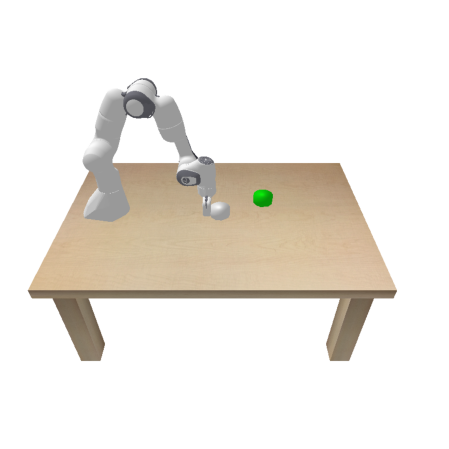

In [9]:
from panda_pushing_env import PandaDiskPushingEnv
from visualizers import GIFVisualizer, NotebookVisualizer
from tqdm.notebook import tqdm

%matplotlib inline

# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# Initialize the simulation environment
env = PandaDiskPushingEnv(visualizer=visualizer, render_non_push_motions=False,  camera_heigh=800, camera_width=800)
env.reset()


# Perform a sequence of 3 random actions:
for i in tqdm(range(3)):
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    if done:
        break

plt.close(fig)

## 2.1 Train a GP model of the pushing dynamics (15 points)

For this part we will train a GP model to approximate the pushing dynamics. We have given you training and validation datasets `pushing_training_data.npy` and `pushing_validation_data.npy`. We will use the dynamics formulation

$$ \mathbf x_{t+1} = \mathbf x_t + f(\mathbf x_t, \mathbf u_t)$$

We can make our GP fit the dynamics by using the mean function $m(\mathbf x_t, \mathbf u_t) = \mathbf x_{t}$

Since our state is 2-dimensional, we must use a multi-output GP. As per the lecture slides, we will be treating each output dimension independently. You can find how to do this in GPytorch [here](https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/Batch_Independent_Multioutput_GP.html).
- Complete `ResidualMean.forward` which should compute the mean as specified above. Note the shape information in the docstring!
- Note that the input to this class is `batch_shape`. This should be the number of GPs we have (1 per output dimension). We have kept this naming convention to be consistent with GPytorch, but be aware this is not the same way we have used 'batch' in the past, i.e. number of independent data points. 
- Complete `MultiTaskGPModel.__init__` by assigning `mean_module` and `covar_module`. You should use the residual mean function you implemented, and an RBF kernel with a scale kernel. For the RBF kernel, you should use `ard_num_dims=5` as an argument. This means rather than using a single lengthscale in the kernel, each dimension of the input will have its own lengthscale. 
- Complete the `PushingDynamicsGP.forward` function
- Notice that we have given you a `PushingDynamics.predict` function. Whenever you are using the model to predict at test time, you should use this function instead of the `PushingDynamics.forward` function
- Complete the `train_dynamics_gp_hyperparameters` function to train the GP hyperparameters. 

You should be able to train using the dataset we provided for you achieving a final loss of below -2.9. 

In [10]:
from learning_uncertain_dynamics import PushingDynamicsGP, MultitaskGPModel, train_dynamics_gp_hyperparams


# Load the training data
train_data = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'pushing_training_data.npy'), allow_pickle=True)

# Convert to torch
train_states = torch.from_numpy(np.stack([d['states'] for d in train_data], axis=0))
train_actions = torch.from_numpy(np.stack([d['actions'] for d in train_data], axis=0))

# Convert to states and next_states format
train_next_states = train_states[:, 1:].reshape(-1, 2) 
train_states = train_states[:, :-1].reshape(-1, 2)
train_actions = train_actions.reshape(-1, 3)

# We use a multitask Gaussian likelihood
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2,
                                                             noise_constraint=gpytorch.constraints.GreaterThan(1e-9)
                                                             )
pushing_gp_model = PushingDynamicsGP(train_states, train_actions, train_next_states, likelihood)
train_dynamics_gp_hyperparams(pushing_gp_model, likelihood, train_states, train_actions, train_next_states, 0.1)


IndexError: tuple index out of range

## 2.2 Train a Neural Network Ensemble model of the pushing dynamics (15 points)

Now we will train a Neural Network ensemble to approximate the residual pushing dynamics. We will train N different models of the form

$$ \mathbf x_{t+1} = \mathbf x_t + f(\mathbf x_t, \mathbf u_t)$$

- Complete `SingleStepDynamicsDataset` in `learning_uncertain_dynamics.py`. You should be able to reuse your code from homework 3
- Complete `ResidualDynamicsModel` in `learning_uncertain_dynamics.py`. You should be able to use your code from homework 3 with small modifications
- Complete `DynamicsNNEnsemble.forward` to make a prediction for every network in the ensemble. 
- Complete `DynamicsNNEnsemble.predict`. This function should return the mean and covariance of the ensemble predictions. You should use the function `batch_cov` from `utils.py` to compute the covariance.
- Train the NN Ensemble in the notebook below. You will then upload the trained model with your code to autograder. 


In [ ]:
from torch.utils.data import DataLoader
from learning_uncertain_dynamics import SingleStepDynamicsDataset, DynamicsNNEnsemble
from torch.nn import functional as F

train_data = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'pushing_training_data.npy'), allow_pickle=True)
validation_data = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'pushing_validation_data.npy'), allow_pickle=True)

# Datasets and Dataloaders
train_dataset = SingleStepDynamicsDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
validation_dataset = SingleStepDynamicsDataset(validation_data)
val_loader = DataLoader(validation_dataset, batch_size=len(validation_dataset))


# Train the dynamics model
pushing_nn_ensemble_model = DynamicsNNEnsemble(2, 3, 10)


# --- Your code here

# ---

# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'dynamics_nn_ensemble_model.pt')
torch.save(pushing_nn_ensemble_model.state_dict(), save_path)


## GP vs NN Ensemble
We can compare the performance of the NN ensemble and the GP by looking at the log likelihood of the validation data. You should see that the GP has log likelihood of above 6, whereas the NN ensemble should have a log likelihood of above 4. 

As a general rule, we would expect the GP to outperform the NN ensemble with a very small dataset. As we increase the size of the dataset, we would expect the NN ensemble to outperform the GP. 

In [ ]:
from torch.distributions import MultivariateNormal

# Load validation data
validation_data = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'pushing_validation_data.npy'), allow_pickle=True)

# Convert to torch
val_states = torch.from_numpy(np.stack([d['states'] for d in validation_data], axis=0))
val_actions = torch.from_numpy(np.stack([d['actions'] for d in validation_data], axis=0))

# Convert to states and next_states format
val_next_states = val_states[:, 1:].reshape(-1, 2) 
val_states = val_states[:, :-1].reshape(-1, 2)
val_actions = val_actions.reshape(-1, 3)

# must put to eval mode
pushing_gp_model.eval()
likelihood.eval()

# Predict with the GP
mu_gp, sigma_gp = pushing_gp_model.predict(val_states, val_actions)

# predict with the NN 
mu_nn, sigma_nn = pushing_nn_ensemble_model.predict(val_states, val_actions)


# Compute log likelihoods
gp_loglikelihood = MultivariateNormal(mu_gp, covariance_matrix=sigma_gp).log_prob(val_next_states).mean()
nn_loglikelihood = MultivariateNormal(mu_nn, covariance_matrix=sigma_nn).log_prob(val_next_states).mean()

print(f'Log-likelihood of the validation data for the GP: {gp_loglikelihood}')
print(f'Log-likelihood of the validation data for the NN Ensemble: {nn_loglikelihood}')

Below we show a visualization of the predicted uncertainties of the GP and the ensemble for a single prediction. Since the dynamics are random, we show different sampled ground truth transitions in blue. 

In [ ]:
# one step plotting comparison GP vs NN ensemble

from utils import plot_uncertainty_propagation

# Load validation data
d = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'visualization_data.npz'), allow_pickle=True)
states = torch.from_numpy(d['states']).to(torch.float32)
actions = torch.from_numpy(d['actions']).to(torch.float32)

# initial mean and sigma
pred_mu_GP = [states[0, 0].clone().reshape(1, 2)]
pred_sigma_GP = [torch.zeros(1, 2, 2)]
pred_mu_nn = [states[0, 0].clone().reshape(1, 2)]
pred_sigma_nn = [torch.zeros(1, 2, 2)]

# Predict next mean and sigma with GP and NN
with torch.no_grad():
    mu_gp, sigma_gp = pushing_gp_model.predict(pred_mu_GP[-1].reshape(-1, 2), actions[0].reshape(-1, 3))
    mu_nn, sigma_nn = pushing_nn_ensemble_model.predict(pred_mu_nn[-1].reshape(-1, 2), actions[0].reshape(-1, 3))
        
    pred_mu_GP.append(mu_gp)
    pred_sigma_GP.append(sigma_gp)  
    pred_mu_nn.append(mu_nn)
    pred_sigma_nn.append(sigma_nn)
    
pred_mu_GP = torch.cat(pred_mu_GP, dim=0)
pred_sigma_GP = torch.cat(pred_sigma_GP, dim=0)
pred_mu_nn = torch.cat(pred_mu_nn, dim=0)
pred_sigma_nn = torch.cat(pred_sigma_nn, dim=0)

# Plot corresponding ellipses
plot_uncertainty_propagation(states[:, :2], pred_mu_GP, pred_sigma_GP, title='GP single-step prediction')
plot_uncertainty_propagation(states[:, :2], pred_mu_nn, pred_sigma_nn, title='NN single-step prediction')


## 3. Uncertainty Propagation with uncertain dynamics (30 points)

In this part of the question you will implement three different approaches for propagating uncertainty through uncertain nonlinear dynamics. For each of these cases we will approximate the distribution of the state at time $t$ as a multivariate Gaussian $p(x_t) = \mathcal{N}(\mu_t, \Sigma_t) $. 

While the GP dynamics assumes each output is independent, you will see that some of these uncertainty propagation techniques introduce correlations between output dimensions over multiple timesteps. For this reason we will be using full $2\times 2$ covariance matrices to represent the covariance of $x_t$

Note that for all of these methods you should use `self.predict` rather than `self.forward`, as `self.predict` will return a mean and covariance matrix.


### 3.1 Certainty Equivalence (propagate the mean) (10 points)

Certainty equivalence is the process of propagating the mean through the non-linear dynamics. At time $t$ we have $x_t \sim p(x_t) = \mathcal{N}(\mu_t, \Sigma_t) $. Then to predict the future we evaluate the dynamics using the mean via $\mu_{t+1}, \Sigma_{t+1} = f(\mu_t, u_t)$. 


- Complete `PushingDynamics.propagate_uncertainty_certainty_equivalence` in `learning_uncertain_dynamics.py`
- Your function should return the predicted mean and covariance matrix as detailed above. 
- Note that `PushingDynamicsGP` and `PushingDynamicsNNEnsemble` inherit from `PushingDynamics`. Your function should work for both GP and NN Ensemble dynamics. 

You should expect to see that the ellipses do not necessarily grow over time. The GP prediction should be close to the ground truth predictions, but the NN ensemble may not. 


In [ ]:
from utils import plot_uncertainty_propagation, rollout_uncertain

d = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'visualization_data.npz'), allow_pickle=True)
states = torch.from_numpy(d['states']).to(torch.float32)
actions = torch.from_numpy(d['actions']).to(torch.float32)

# set propagation method
pushing_gp_model.propagation_method = 'certainty_equivalence'
pushing_nn_ensemble_model.propagation_method = 'certainty_equivalence'

# Do predictions
pred_mu_gp, pred_sigma_gp = rollout_uncertain(pushing_gp_model, states[0, 0], actions)
pred_mu_nn, pred_sigma_nn = rollout_uncertain(pushing_nn_ensemble_model, states[0, 0], actions)


# Plot corresponding ellipses
plot_uncertainty_propagation(states, pred_mu_gp, pred_sigma_gp, 'GP certainty equivalence')
plot_uncertainty_propagation(states, pred_mu_nn, pred_sigma_nn, 'NN Ensemble certainty equivalence')

## 3.2 Moment matching via sampling (10 points)

Here at time $t$ we again have $x_t \sim p(x_t) = \mathcal{N}(\mu_t, \Sigma_t) $. 

To perform this process we must first sample $K$ states  $ \{x^k_t\}^K \sim \mathcal{N}(\mu_t, \Sigma_t)$. 

Next, we evaluate the dynamics at each of these $K$ states to get $K$ Gaussian predictions $\mu^k_{t+1}, \Sigma^k_{t+1} = f(x^k_t, u_t)$. 

Then we sample a single state from each of these $K$ Gaussians: $x^k_{t+1} \sim \mathcal{N}(\mu^k_{t+1}, \Sigma^k_{t+1})$

Finally, we fit a Gaussian by estimating the mean and covariance of the set of samples $\{x^k_{t+1}\}^K$

- Complete `PushingDynamics.propagate_uncertainty_moment_matching` to perform moment matching as described above
- Your function should work when $\Sigma_t$ is zero. This indicates that the exact value of $x_t$ is already known, such as for the first timestep where we know the current state. You will have to check if $\Sigma_t$ is zero and treat is as a special case.
- As with certainty equivalence, this function should work with both the NN ensemble and the GP.
- You can use the class `MultivariateNormal` from `torch.distributions`. You can instantiate a distribution with `MultivariateNormal(mean, covariance_matrix=sigma)`. Note that you should use the keyword `covariance_matrix` - this is because there are different ways of parameterizing the covariance matrix that are sometimes more numerically convenient. 
- You can sample from `MultivariateNormal` with `.sample(sample_shape)`, where sample_shape is a tuple. 

You should see that now the uncertainty grows with time. You should also see that the GP has better prediction performance, almost all of the ground truth trajectories being within the uncertainty ellipses. 


In [ ]:
from utils import plot_uncertainty_propagation, rollout_uncertain

d = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'visualization_data.npz'), allow_pickle=True)
states = torch.from_numpy(d['states']).to(torch.float32)
actions = torch.from_numpy(d['actions']).to(torch.float32)

# set propagation method
pushing_gp_model.propagation_method = 'moment_matching'
pushing_nn_ensemble_model.propagation_method = 'moment_matching'

# Do predictions
pred_mu_gp, pred_sigma_gp = rollout_uncertain(pushing_gp_model, states[0, 0], actions)
pred_mu_nn, pred_sigma_nn = rollout_uncertain(pushing_nn_ensemble_model, states[0, 0], actions)


# Plot corresponding ellipses
plot_uncertainty_propagation(states, pred_mu_gp, pred_sigma_gp, 'GP moment matching')
plot_uncertainty_propagation(states, pred_mu_nn, pred_sigma_nn, 'NN Ensemble moment matching')

## 3.3 Linearization (10 points)

The linearization technique exploits the fact that a linear function of a Gaussian random vector is itself a Gaussian random vector. Consider $\mathbf X \sim \mathcal{N}(\mu, \Sigma)$, and $\mathbf Y = A \mathbf X$

Then $\mathbf Y$ is also a Gaussian random vector, with mean given by

$$ \mathbb{E}[\mathbf Y] = \mathbb{E}[A \mathbf X] = A \mathbb{E}[ \mathbf X ] = A \mu $$

and covariance given by 

\begin{align}
\text{Cov}(\mathbf Y) &= \mathbb{E}[(Y - \mathbb{E}[\mathbf Y])(Y - \mathbb{E}[\mathbf Y])^T] \\ 
&= \mathbb{E}[(AX - A\mathbb{E}[\mathbf X])(AX - A \mathbb{E}[\mathbf X])^T] \\ 
&= A\mathbb{E}[(X - \mathbb{E}[\mathbf X])(X - \mathbb{E}[\mathbf X])^T]A^T \\ 
&= A\Sigma A^T \\ 
\end{align}

The above equations motivate the use of a linearization of the non-linear mean function in order to propagate the uncertainty. The equations for propagating the uncertainty are given by 

$$ \mu_{t+1}, \hat{\Sigma}_{t+1} = f_{GP}(\mu_t, u_t) $$
$$ \Sigma_{t+1} = \hat{\Sigma}_{t+1} + A \Sigma_t A^T$$

Where $A$ is the linearization of the GP mean function
$$ A = \frac{\partial \mu_{t+1}}{\partial \mu_t} (\mu_t, u_t)$$

- Complete the function `PushingDynamicsGP.propagate_uncertainty_linearization` using the formula above. 
- In principle this linearization can be applied to the NN ensemble - it just requires computing the linearization of the NN ensemble mean prediction. However, we will only consider method for the GP. 
- We have given a method for computing $A$ above which is already in your starter code

You should see that the uncertainty ellipses grow with time. However, comparing the below plot to the moment-matching plot for the GP, you should see that the uncertainty ellipses for the linearization technique are generally smaller. 


In [ ]:
from utils import plot_uncertainty_propagation, rollout_uncertain

d = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'visualization_data.npz'), allow_pickle=True)
states = torch.from_numpy(d['states']).to(torch.float32)
actions = torch.from_numpy(d['actions']).to(torch.float32)

# set propagation method
pushing_gp_model.propagation_method = 'linearization'

# Do predictions
pred_mu_gp, pred_sigma_gp = rollout_uncertain(pushing_gp_model, states[0, 0], actions)


# Plot corresponding ellipses
plot_uncertainty_propagation(states, pred_mu_gp, pred_sigma_gp, 'GP linearization')


# 4. Using Uncertain Dynamics with MPPI (20 points)

## 4.1 Obstacle Free Case (5 points)

Now you will use the GP model and the uncertainty propagation techniques with MPPI to push the object to the goal. 

Note that all the uncertainty propagation techniques previously took the form of

$$ \mu_{t+1}, \Sigma_{t+1} = f(\mu_t, \Sigma_t, u_t) $$

To easily incorporate this within our MPPI implementation we will be performing MPPI with an augmented state, where the state in MPPI will be $(\mu, \Sigma)$ and the actions remain $u$. 

We will use the following cost function to perform MPPI:

$$\text{Cost}(\mu_t, \Sigma_t, u_t) = (\mu_t - x_{goal})^T(\mu_t - x_{goal}) + \text{trace} (\Sigma_t)$$

Why do we use this cost function? Intuitively trajectories minimizing this cost function will reach the goal while also having low overall uncertainty.

It is also equivalent to minimizing the **Expected Cost**, since we have that for any random vector $x$ with mean $\mu$ and covariance $\Sigma$ we have

$$\mathbb{E}\left[ \mathbf x^T Q \mathbf x \right ] = \mu^T Q \mu + \text{trace}( Q \Sigma) $$

This means we can interpret minimizing the cost function above as finding trajectories that have low cost **on average**. An explanation for the above formula for expected cost can be found [here](https://stats.stackexchange.com/questions/48066/expected-value-of-quadratic-form)




- Complete the functions `PushingController._compute_dynamics` and `PushingController.control`. 
- `_compute_dynamics` should use `self.model.propagate_uncertainty` to propagate the uncertainty. The state in MPPI will be ($\mu, \Sigma$), where $\Sigma$ has been reshaped into a vector of length 4. 
- Complete `free_pushing_cost_function`



In [ ]:
# now let's try and do MPPI to get to the goal using our dynamics
# Control on an obstacle free environment

%matplotlib inline

from learning_uncertain_dynamics import PushingController, free_pushing_cost_function

from panda_pushing_env import TARGET_POSE_FREE, DISK_RADIUS

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

pushing_gp_model.propagation_method = 'certainty_equivalence'
cost = free_pushing_cost_function
env = PandaDiskPushingEnv(visualizer=visualizer, render_non_push_motions=False,  
                      camera_heigh=800, camera_width=800, render_every_n_steps=5, include_obstacle=False)

controller = PushingController(env, pushing_gp_model, 
                               cost, num_samples=100, horizon=10)
env.reset()

state_0 = env.reset()
state = state_0

num_steps_max = 20

env.reset()
for i in tqdm(range(num_steps_max)):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    if done:
        break


# Evaluate if goal is reached
end_state = env.get_state()
target_state = TARGET_POSE_FREE
goal_distance = np.linalg.norm(end_state[:2]-target_state[:2]) # evaluate only position, not orientation
goal_reached = goal_distance < 1.2*DISK_RADIUS

print(f'GOAL REACHED: {goal_reached}')
        
        
plt.close(fig)



## 4.2 - Cost Function for Obstacle Avoidance (15 points)

Now we will add an obstacle to the environment. The obstacle is a purple cylinder on the table. 

### 4.2 a) Collision checking the mean (7 points)

You should implement a new cost function to reach the goal while avoiding the obstacle. The cost should be


$$\text{Cost}(\mu_t, \Sigma_t, u_t) = (\mu_t - x_{goal})^T(\mu_t - x_{goal}) + \text{trace} (\Sigma_t) + 100 \texttt{in_collision}(\mu_t)$$

With `in_collision` being 1 if the disk is in collision with the obstacle and 0 otherwise. This should add an additional state cost of 100 whenever a state is in collision. Intuitively, minimizing this cost will find trajectories with means that reach the goal and avoid the obstacle, while minimizing the total uncertainty. 


**TODO:**

- Implement `obstacle_avoidance_pushing_cost_function` in `learning_state_dynamics.py`.
- As part of this question you will need to implement a method of detecting collision between two 2D circles.

If implemented successfully, you should see the robot pushing the cylinder around the obstacle to the goal. The robot should complete the task within the 20 steps, but may take 15-20 steps to do so. Even with a good dynamics model the robot may occasionally overshoot the goal, but should succeed more often than not.




In [ ]:
# now let's try and do MPPI to get to the goal using our dynamics
# Control on an obstacle free environment

%matplotlib inline

from learning_uncertain_dynamics import PushingController, obstacle_avoidance_pushing_cost_function

from panda_pushing_env import TARGET_POSE_OBSTACLES, DISK_RADIUS

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

pushing_gp_model.propagation_method = 'moment_matching'
cost = obstacle_avoidance_pushing_cost_function
env = PandaDiskPushingEnv(visualizer=visualizer, render_non_push_motions=False,  
                      camera_heigh=800, camera_width=800, render_every_n_steps=5, include_obstacle=True)

controller = PushingController(env, pushing_gp_model, 
                               cost, num_samples=100, horizon=10)
env.reset()

state_0 = env.reset()
state = state_0

num_steps_max = 20

env.reset()
for i in tqdm(range(num_steps_max)):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    if done:
        break


# Evaluate if goal is reached
end_state = env.get_state()
target_state = TARGET_POSE_OBSTACLES
goal_distance = np.linalg.norm(end_state[:2]-target_state[:2]) # evaluate only position, not orientation
goal_reached = goal_distance < 1.2*DISK_RADIUS

print(f'GOAL REACHED: {goal_reached}')
        
        
plt.close(fig)

### 4.2 a) Expected cost with samples (8 points)

In section 4.1 we discussed that the cost we were using was the **Expected Cost**, where the expectation was taken with respect to our state uncertainty. 

In the previous section we only performed collision checking of the mean. Note that 

$$ \mathbb{E}\left[ (x - x_{goal})^T(x - x_{goal}) + 100 \texttt{in_collision}(x)\right] = (\mu - x_{goal})^T(\mu - x_{goal})  + \text{trace} (\Sigma) + 100 \mathbb{E}\left[\texttt{in_collision}(x)\right]$$

Since the expectation is a linear operator. In the previous question we used $\texttt{in_collision}(\mu)$ instead of $\mathbb{E}\left[\texttt{in_collision}(x)\right]$, but these two are not equal. For instance we might expect that if we are near the obstacle and have high uncertainty, then we have a higher chance of collision. We can instead approximate the collision cost with samples:

$$ \{x_k\}^K \sim \mathcal{N}(\mu, \Sigma) $$
$$ \mathbb{E}\left[\texttt{in_collision}(x)\right] \approx \frac{1}{K}\sum^K_{k=1} \texttt{in_collision}(x_k)$$



**TODO:**

- Implement `obstacle_avoidance_pushing_cost_function_samples` in `learning_state_dynamics_gp.py`.
- You should use samples to estimate the expectation of the collision detection
- You should use K=10


Once you have implemented this, you can run the code below to use the cost function.

If implemented successfully, you should see the robot pushing the cylinder around the obstacle to the goal. The robot should complete the task within the 20 steps, but may take 15-20 steps to do so. Even with a good dynamics model the robot may occasionally overshoot the goal, but should succeed more often than not.



In [ ]:
# now let's try and do MPPI to get to the goal using our dynamics
# Control on an obstacle free environment

%matplotlib inline

from learning_uncertain_dynamics import obstacle_avoidance_pushing_cost_function_samples
from panda_pushing_env import TARGET_POSE_OBSTACLES, DISK_RADIUS

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

pushing_gp_model.propagation_method = 'moment_matching'
cost = obstacle_avoidance_pushing_cost_function_samples
env = PandaDiskPushingEnv(visualizer=visualizer, render_non_push_motions=False,  
                      camera_heigh=800, camera_width=800, render_every_n_steps=5, include_obstacle=True)

controller = PushingController(env, pushing_gp_model, 
                               cost, num_samples=100, horizon=10)
env.reset()

state_0 = env.reset()
state = state_0

# num_steps_max = 100
num_steps_max = 20

env.reset()
for i in tqdm(range(num_steps_max)):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    if done:
        break


# Evaluate if goal is reached
end_state = env.get_state()
target_state = TARGET_POSE_OBSTACLES
goal_distance = np.linalg.norm(end_state[:2]-target_state[:2]) # evaluate only position, not orientation
goal_reached = goal_distance < 1.2*DISK_RADIUS

print(f'GOAL REACHED: {goal_reached}')
        
        
plt.close(fig)